# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import PIL
from PIL import Image
from tqdm.auto import tqdm

import torch
import torch.nn.functional as F
from torchvision.transforms import Compose, Resize, CenterCrop, Normalize, ToTensor
from torchvision.datasets import CIFAR100, Flickr8k, ImageFolder
from torch.utils.data import DataLoader

from timm.models import create_model

import os
import warnings
warnings.filterwarnings('ignore')
print("Libraries Imported Successfully!")

Libraries Imported Successfully!


In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Device: {device}")

Device: cuda


In [3]:
if device == 'cuda':
    !nvidia-smi
else:
    print("CUDA device is not available.")

Wed Jun 19 05:17:59 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.129.03             Driver Version: 535.129.03   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P8               9W /  70W |      3MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

# Directory & Helper Functions

In [4]:
# Define the directory in Kaggle environment where you want to save the files
save_dir = '/kaggle/working/attention_maps/'

# Create the directory if it doesn't exist
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

In [5]:
def save_img(img, filepath):
    img = np.asarray(img)
    plt.figure(figsize=(10, 10))
    plt.imshow(img)
    plt.axis('off')
    plt.savefig(filepath)
    plt.close()

In [6]:
def save_img2(img1, img2, filepath, alpha=0.5):
    img1 = np.asarray(img1)
    img2 = np.asarray(img2)
    plt.figure(figsize=(10, 10))
    plt.imshow(img1)
    plt.imshow(img2, alpha=alpha)
    plt.axis('off')
    plt.savefig(filepath)
    plt.close()

In [7]:
def my_forward_wrapper(attn_obj):
    def my_forward(x):
        B, N, C = x.shape
        qkv = attn_obj.qkv(x).reshape(B, N, 3, attn_obj.num_heads, C // attn_obj.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv.unbind(0)   

        attn = (q @ k.transpose(-2, -1)) * attn_obj.scale
        attn = attn.softmax(dim=-1)
        attn = attn_obj.attn_drop(attn)
        attn_obj.attn_map = attn
        attn_obj.cls_attn_map = attn[:, :, 0, 2:]

        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = attn_obj.proj(x)
        x = attn_obj.proj_drop(x)
        return x
    return my_forward

In [8]:
def plot_cls_weights(cls_weights, img_resized, filepath):
    num_cls_weights = len(cls_weights)

    # Calculate the number of rows and columns for the subplots
    num_cols = 4  # Adjust as needed
    num_rows = (num_cls_weights + num_cols - 1) // num_cols

    # Create a figure and a grid of subplots
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(18, 4 * num_rows))

    # Iterate over the cls_weights and plot them in the subplots
    for i, cls_weight in enumerate(cls_weights):
        row = i // num_cols
        col = i % num_cols

        if num_rows == 1:
            ax = axes[col]
        else:
            ax = axes[row, col]

        cls_resized = F.interpolate(cls_weight.view(1, 1, 14, 14), (224, 224), mode='bilinear').view(224, 224, 1)

        ax.imshow(img_resized)
        ax.imshow(cls_resized, alpha=0.7)
        ax.set_title(f'Class Weight {i+1}')
        ax.axis('off')

    # Adjust spacing between subplots
    plt.subplots_adjust(wspace=0.1, hspace=0.3)
    
    plt.savefig(filepath)
    
    plt.close()

# Data & Transformations

In [9]:
# Define the transformation to apply to each image
transform = Compose([
    Resize((224, 224)),  # Pass the size as a tuple
    ToTensor(),
    Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [10]:
# image_folder = "/kaggle/input/flickr-image-dataset/flickr30k_images"
# dataset = ImageFolder(root = os.path.join(image_folder, 'flickr30k_images'), transform = transform)

In [11]:
image_folder = "/kaggle/input/imagenetmini-1000/imagenet-mini"
dataset = ImageFolder(root = os.path.join(image_folder, 'val'), transform = transform)

In [12]:
data_loader = DataLoader(dataset, batch_size=1, shuffle=True)

# Model

In [13]:
# Load the model and modify the attention layer
model = create_model('deit_small_distilled_patch16_224', pretrained=True).to(device)

device = next(model.parameters()).device  # Get the device from the model's parameters

model.safetensors:   0%|          | 0.00/89.8M [00:00<?, ?B/s]

In [14]:
# Replace forward function in all blocks
for block in tqdm(model.blocks):
    block.attn.forward = my_forward_wrapper(block.attn)

  0%|          | 0/12 [00:00<?, ?it/s]

# Forward Pass & Saving Images

In [15]:
# Process and visualize 100 images
top_k_scores = []
mean_scores = []
k = 15

In [16]:
top_k_scores = {i: [] for i in range(len(model.blocks))}
mean_scores = {i: [] for i in range(len(model.blocks))}

for idx, (img, _) in tqdm(enumerate(data_loader)):
    if idx >= 100:
        break

    x = img.to(device)  # Move input to the same device as the model

    # Ensure the input has the correct shape
    if len(x.shape) == 3:
        x = x.unsqueeze(0)  # Add batch dimension

    # Pass the image through the model
    with torch.no_grad():
        y = model(x)
    
    # Extract attention maps and class scores from the model's blocks
    for i, block in enumerate(model.blocks):
        attn_map = block.attn.attn_map.max(dim=1).values.squeeze(0).detach()
        cls_weight = block.attn.cls_attn_map.mean(dim=1).view(14, 14).detach()

        # Collect top K attention scores
        top_k = torch.topk(cls_weight.view(-1), k).values.cpu().numpy()  # Move to CPU for numpy
        top_k_scores[i].extend(top_k)
    
        # Collect all sorted scores
        _, sorted_indices = torch.sort(cls_weight.view(-1), descending=True)
        sorted_values = cls_weight.view(-1)[sorted_indices].cpu().numpy()
        mean_scores[i].append(sorted_values)
    
    # Reshape and normalize the images and attention maps for visualization
    img_resized = x.squeeze(0).permute(1, 2, 0) * 0.5 + 0.5
    cls_resized = F.interpolate(cls_weight.view(1, 1, 14, 14), (224, 224), mode='bilinear').view(224, 224, 1)

    # Move images back to CPU for saving if necessary
    img_resized_cpu = img_resized.cpu()
    cls_resized_cpu = cls_resized.cpu()

    # Save the original image, attention map, and the overlay
    save_img(img_resized_cpu, os.path.join(save_dir, f'{idx}_img.png'))
    save_img(cls_resized_cpu, os.path.join(save_dir, f'{idx}_attn_map.png'))
    save_img2(img_resized_cpu, cls_resized_cpu, os.path.join(save_dir, f'{idx}_saliencymap.png'))
    
    if (idx + 1) % 10 == 0:
        print(f"Image Number: {idx+1}")
        print(f"Images Saved for: {idx+1}")
        print("-------------------------------------------------------------------------")


0it [00:00, ?it/s]

Image Number: 10
Images Saved for: 10
-------------------------------------------------------------------------
Image Number: 20
Images Saved for: 20
-------------------------------------------------------------------------
Image Number: 30
Images Saved for: 30
-------------------------------------------------------------------------
Image Number: 40
Images Saved for: 40
-------------------------------------------------------------------------
Image Number: 50
Images Saved for: 50
-------------------------------------------------------------------------
Image Number: 60
Images Saved for: 60
-------------------------------------------------------------------------
Image Number: 70
Images Saved for: 70
-------------------------------------------------------------------------
Image Number: 80
Images Saved for: 80
-------------------------------------------------------------------------
Image Number: 90
Images Saved for: 90
------------------------------------------------------------------

# Visualizations

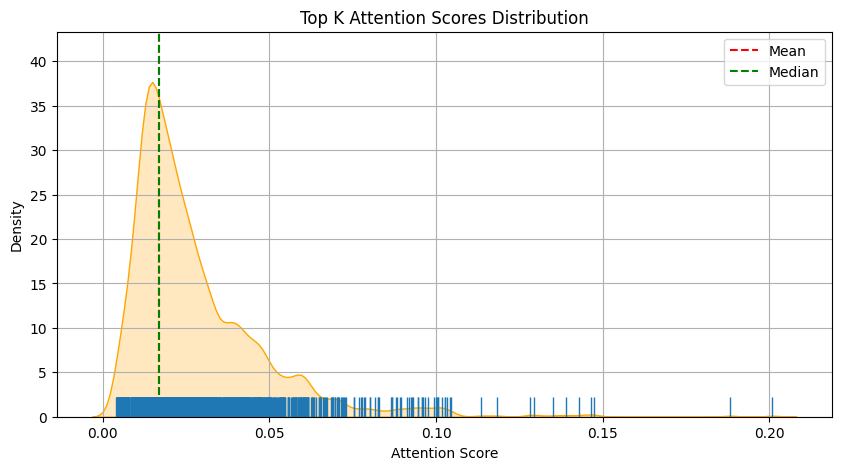

<Figure size 640x480 with 0 Axes>

In [17]:
# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 5))

# Convert the list to a NumPy array
top_k_scores_array = np.array(top_k_scores[i])

# Calculate mean and median
mean_score = np.mean(top_k_scores_array[i])
median_score = np.median(top_k_scores_array[i])

# Plot the KDE
sns.kdeplot(top_k_scores_array, fill=True, color='orange', bw_adjust=0.5, ax=ax)

# Add vertical lines for mean and median
ax.axvline(mean_score, color='r', linestyle='--', label='Mean')
ax.axvline(median_score, color='g', linestyle='--', label='Median')

# Add a rug plot
sns.rugplot(top_k_scores_array, height=0.05, ax=ax)

# Customize the plot
ax.set_title('Top K Attention Scores Distribution')
ax.set_xlabel('Attention Score')
ax.set_ylabel('Density')
ax.grid(True)
ax.legend()
plt.show()

# Save the figure
plt.savefig(os.path.join(save_dir, 'top_k_scores_distribution.png'), bbox_inches='tight')

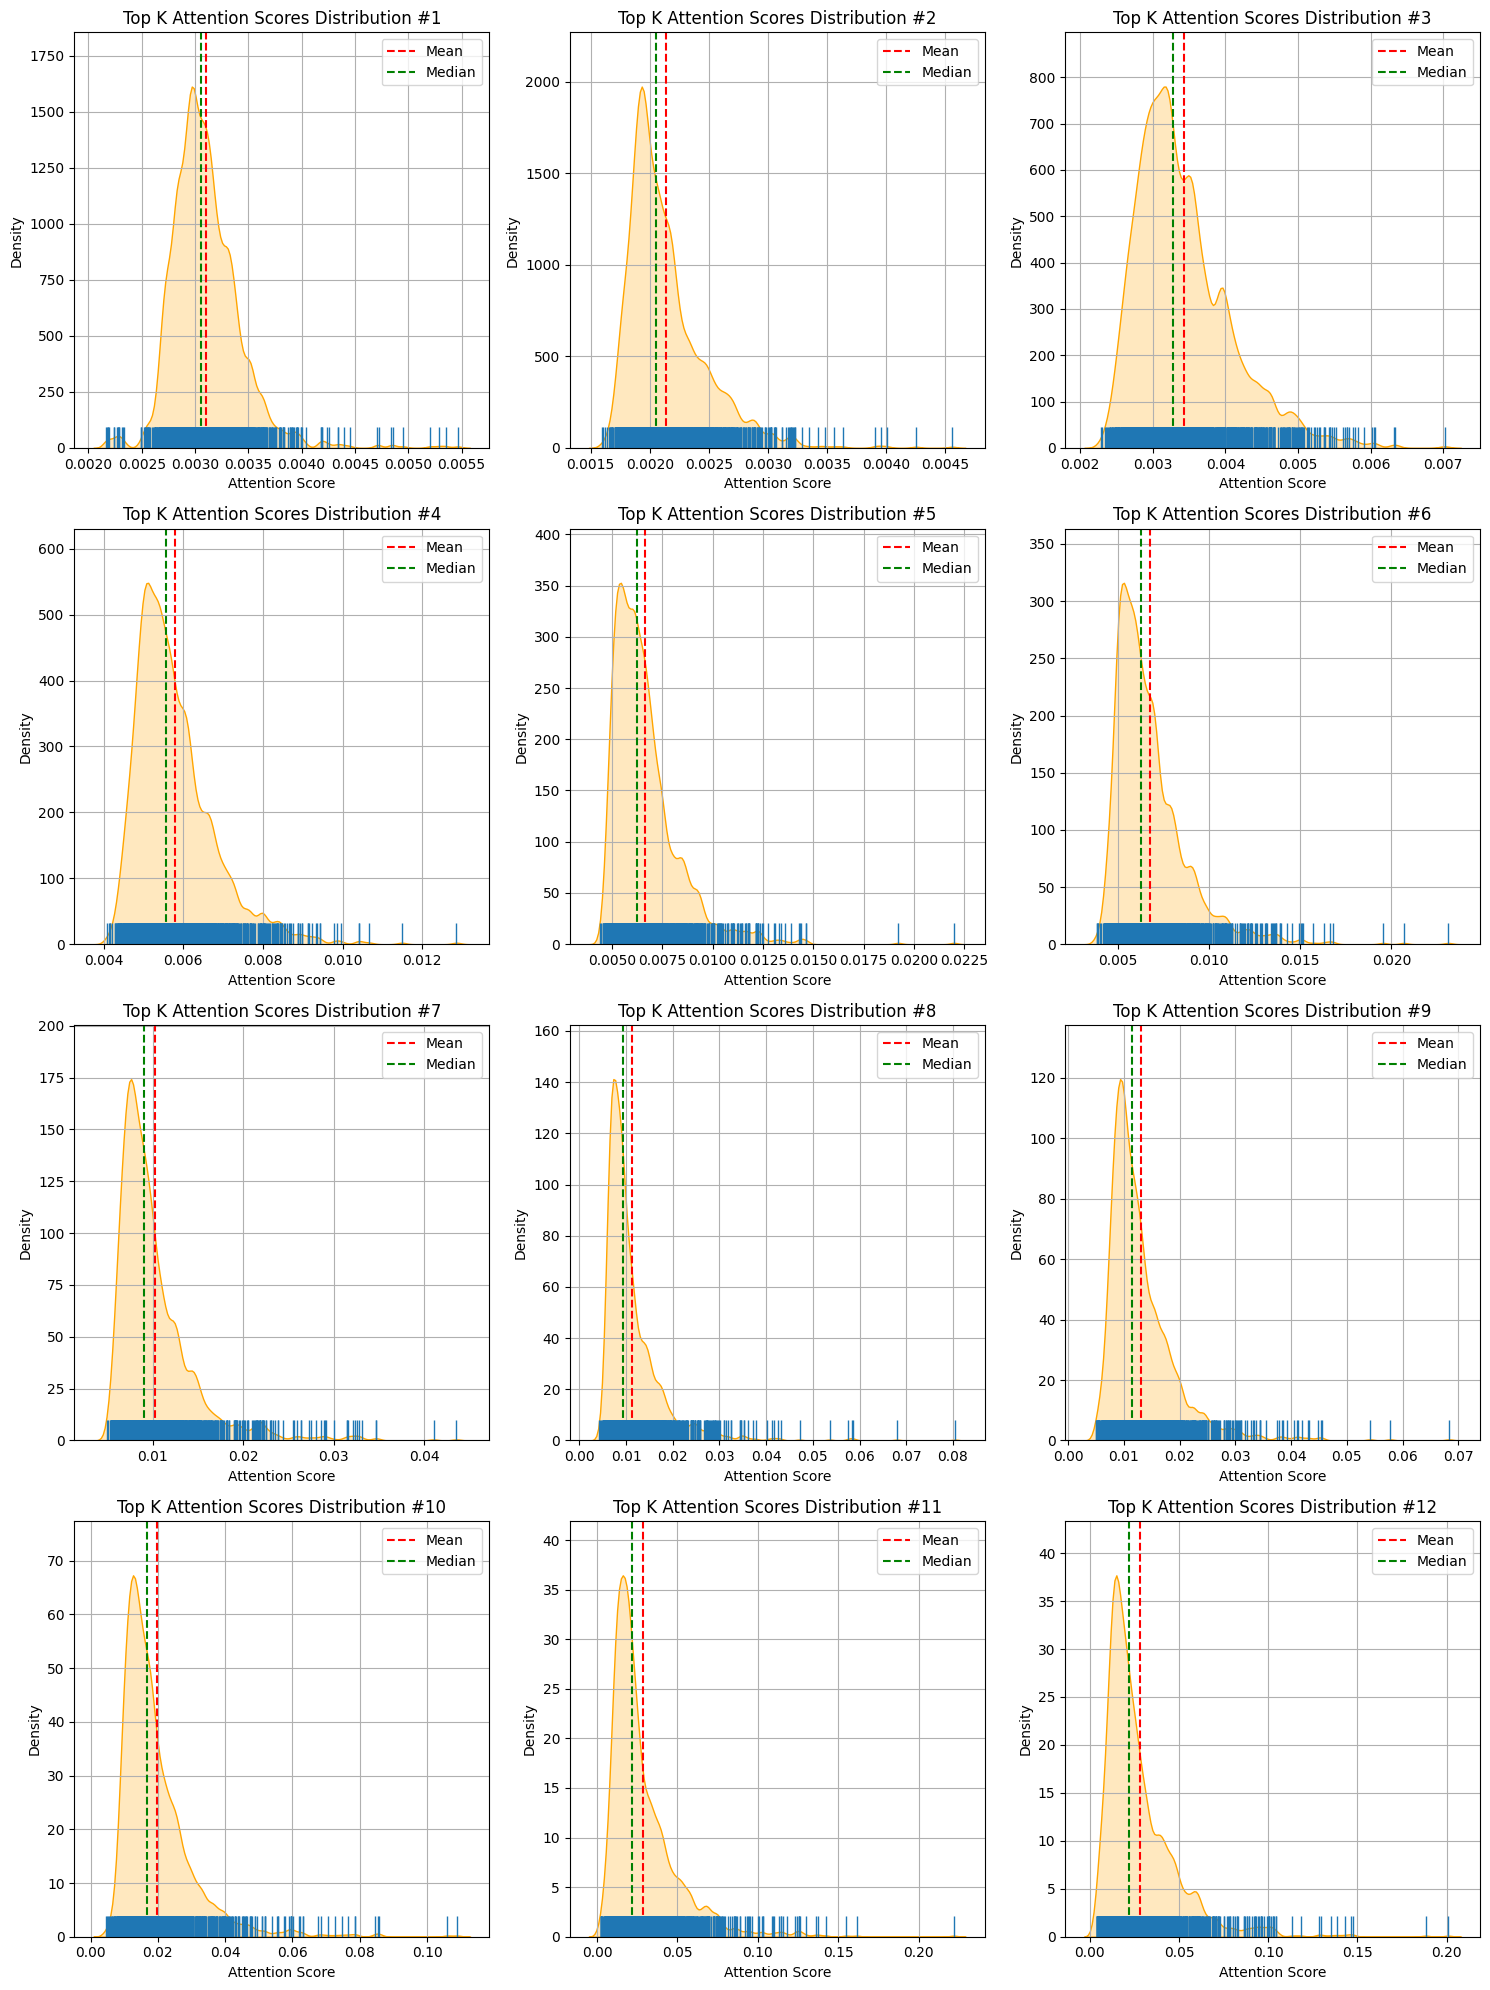

In [18]:
# Save directory
save_dir = './plots/'

# Ensure the directory exists
os.makedirs(save_dir, exist_ok=True)

# Create a figure and axis with 4 rows and 3 columns
fig, axs = plt.subplots(nrows=4, ncols=3, figsize=(15, 20))

# Flatten the axis array for easier indexing
axs = axs.flatten()

# Loop through each subplot and plot the data
for i, ax in enumerate(axs):
    if i < len(top_k_scores):
        # Convert the list to a NumPy array
        top_k_scores_array = np.array(top_k_scores[i])

        # Calculate mean and median
        mean_score = np.mean(top_k_scores_array)
        median_score = np.median(top_k_scores_array)

        # Plot the KDE
        sns.kdeplot(top_k_scores_array, fill=True, color='orange', bw_adjust=0.5, ax=ax)

        # Add vertical lines for mean and median
        ax.axvline(mean_score, color='r', linestyle='--', label='Mean')
        ax.axvline(median_score, color='g', linestyle='--', label='Median')

        # Add a rug plot
        sns.rugplot(top_k_scores_array, height=0.05, ax=ax)

        # Customize the plot
        ax.set_title(f'Top K Attention Scores Distribution #{i+1}')
        ax.set_xlabel('Attention Score')
        ax.set_ylabel('Density')
        ax.grid(True)
        ax.legend()

# Adjust layout to prevent overlap
plt.tight_layout()

# Save the figure
plt.savefig(os.path.join(save_dir, 'top_k_scores_distributions.png'), bbox_inches='tight')

# Show the plot
plt.show()

# Last Block

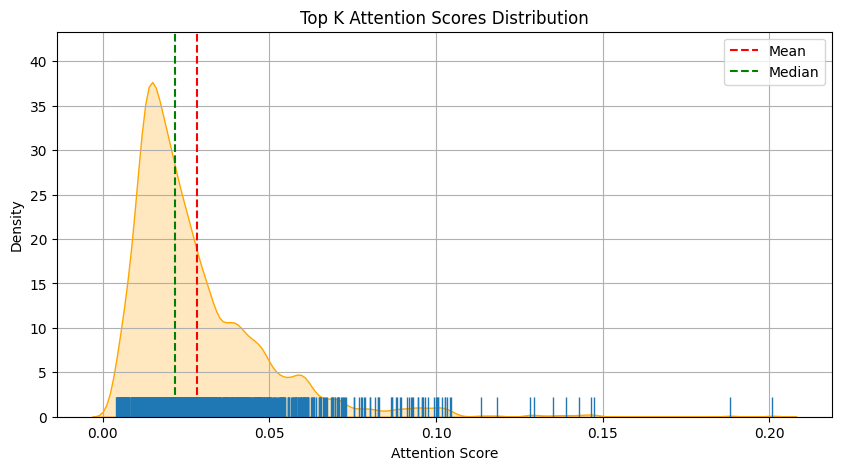

<Figure size 640x480 with 0 Axes>

In [19]:
# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 5))

# Convert the list to a NumPy array
top_k_scores_array = np.array(top_k_scores[11])

# Calculate mean and median
mean_score = np.mean(top_k_scores_array)
median_score = np.median(top_k_scores_array)

# Plot the KDE
sns.kdeplot(top_k_scores_array, fill=True, color='orange', bw_adjust=0.5, ax=ax)

# Add vertical lines for mean and median
ax.axvline(mean_score, color='r', linestyle='--', label='Mean')
ax.axvline(median_score, color='g', linestyle='--', label='Median')

# Add a rug plot
sns.rugplot(top_k_scores_array, height=0.05, ax=ax)

# Customize the plot
ax.set_title('Top K Attention Scores Distribution')
ax.set_xlabel('Attention Score')
ax.set_ylabel('Density')
ax.grid(True)
ax.legend()
plt.show()

# Save the figure
plt.savefig(os.path.join(save_dir, 'top_k_scores_distribution.png'), bbox_inches='tight')

In [20]:
# # Print out the top K scores 
# print("Top K Attention Scores: ", top_k_scores)

In [21]:
# Assuming mean_k_scores is a list of numpy arrays
mean_scores_array = np.array(mean_scores[11])
overall_mean = np.mean(mean_scores_array, axis=0)
overall_mean

array([7.40445554e-02, 5.42681366e-02, 4.37485464e-02, 3.74653116e-02,
       3.26564610e-02, 2.90423129e-02, 2.51144525e-02, 2.21611876e-02,
       1.94808170e-02, 1.77408271e-02, 1.60360411e-02, 1.46864066e-02,
       1.34346755e-02, 1.23021556e-02, 1.15628215e-02, 1.09598925e-02,
       1.03966380e-02, 9.88519844e-03, 9.38061997e-03, 8.91620107e-03,
       8.47398955e-03, 8.12835619e-03, 7.84741342e-03, 7.52675813e-03,
       7.24973436e-03, 7.01145409e-03, 6.75168261e-03, 6.49724016e-03,
       6.27893349e-03, 6.09359983e-03, 5.88996150e-03, 5.70589071e-03,
       5.49346069e-03, 5.27876755e-03, 5.14047919e-03, 5.00018615e-03,
       4.85395361e-03, 4.69093490e-03, 4.55525192e-03, 4.41897567e-03,
       4.25049569e-03, 4.12683282e-03, 4.04114649e-03, 3.93199455e-03,
       3.81269120e-03, 3.68367415e-03, 3.57620930e-03, 3.49592068e-03,
       3.41676991e-03, 3.34208342e-03, 3.25732958e-03, 3.16436123e-03,
       3.08947498e-03, 3.01004061e-03, 2.93451222e-03, 2.87055853e-03,
      

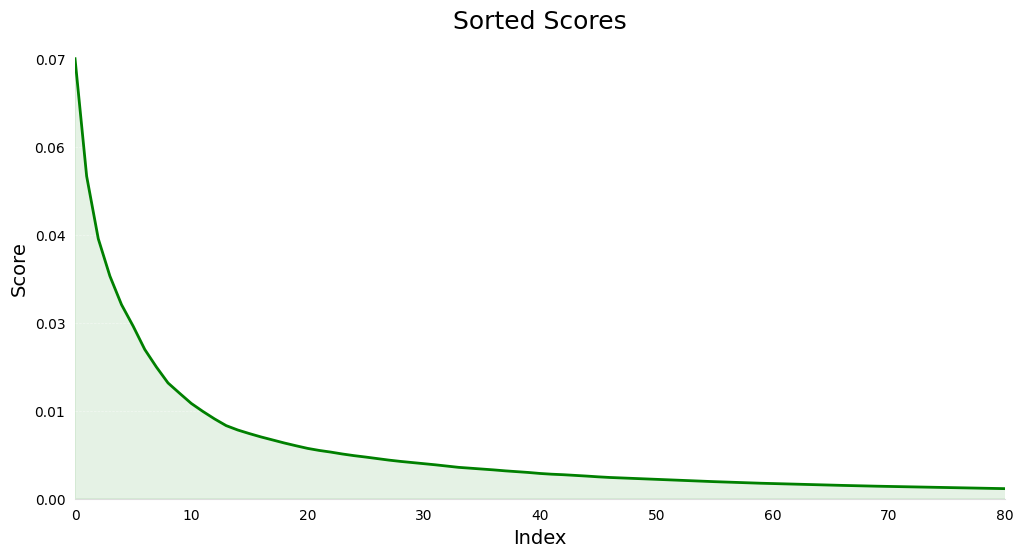

In [22]:
# Assuming sorted_values is the NumPy array containing the sorted values
indices = range(len(overall_mean))

# Create a figure and axis
fig, ax = plt.subplots(figsize=(12, 6))

# Plot the sorted values against the indices using seaborn
sns.lineplot(x=indices, y=overall_mean, ax=ax, linewidth=2, color='green')

# Shade the area below the line
ax.fill_between(indices, overall_mean, color='green', alpha=0.1)

# Simplify the plot by removing spines and ticks
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_color('#DDDDDD')
ax.tick_params(bottom=False, left=False)

# Set the title and axis labels with a simpler style
ax.set_title('Sorted Scores', fontsize=18)
ax.set_xlabel('Index', fontsize=14)
ax.set_ylabel('Score', fontsize=14)

# Adjust x-axis and y-axis limits
ax.set_xlim(left=-0, right=80)
ax.set_ylim(bottom=0, top=max(overall_mean)*1.05)

# Set custom y-axis tick marks and labels
y_ticks = np.arange(0, max(overall_mean)*1.05, step=max(overall_mean)/5)
y_labels = [f"{val:.2f}" for val in y_ticks]
ax.set_yticks(y_ticks)
ax.set_yticklabels(y_labels)

# Reduce grid to horizontal lines only and style them minimally
ax.grid(axis='y', color='white', linestyle='--', linewidth=0.5, alpha=0.5)

# Show the plot
plt.show()


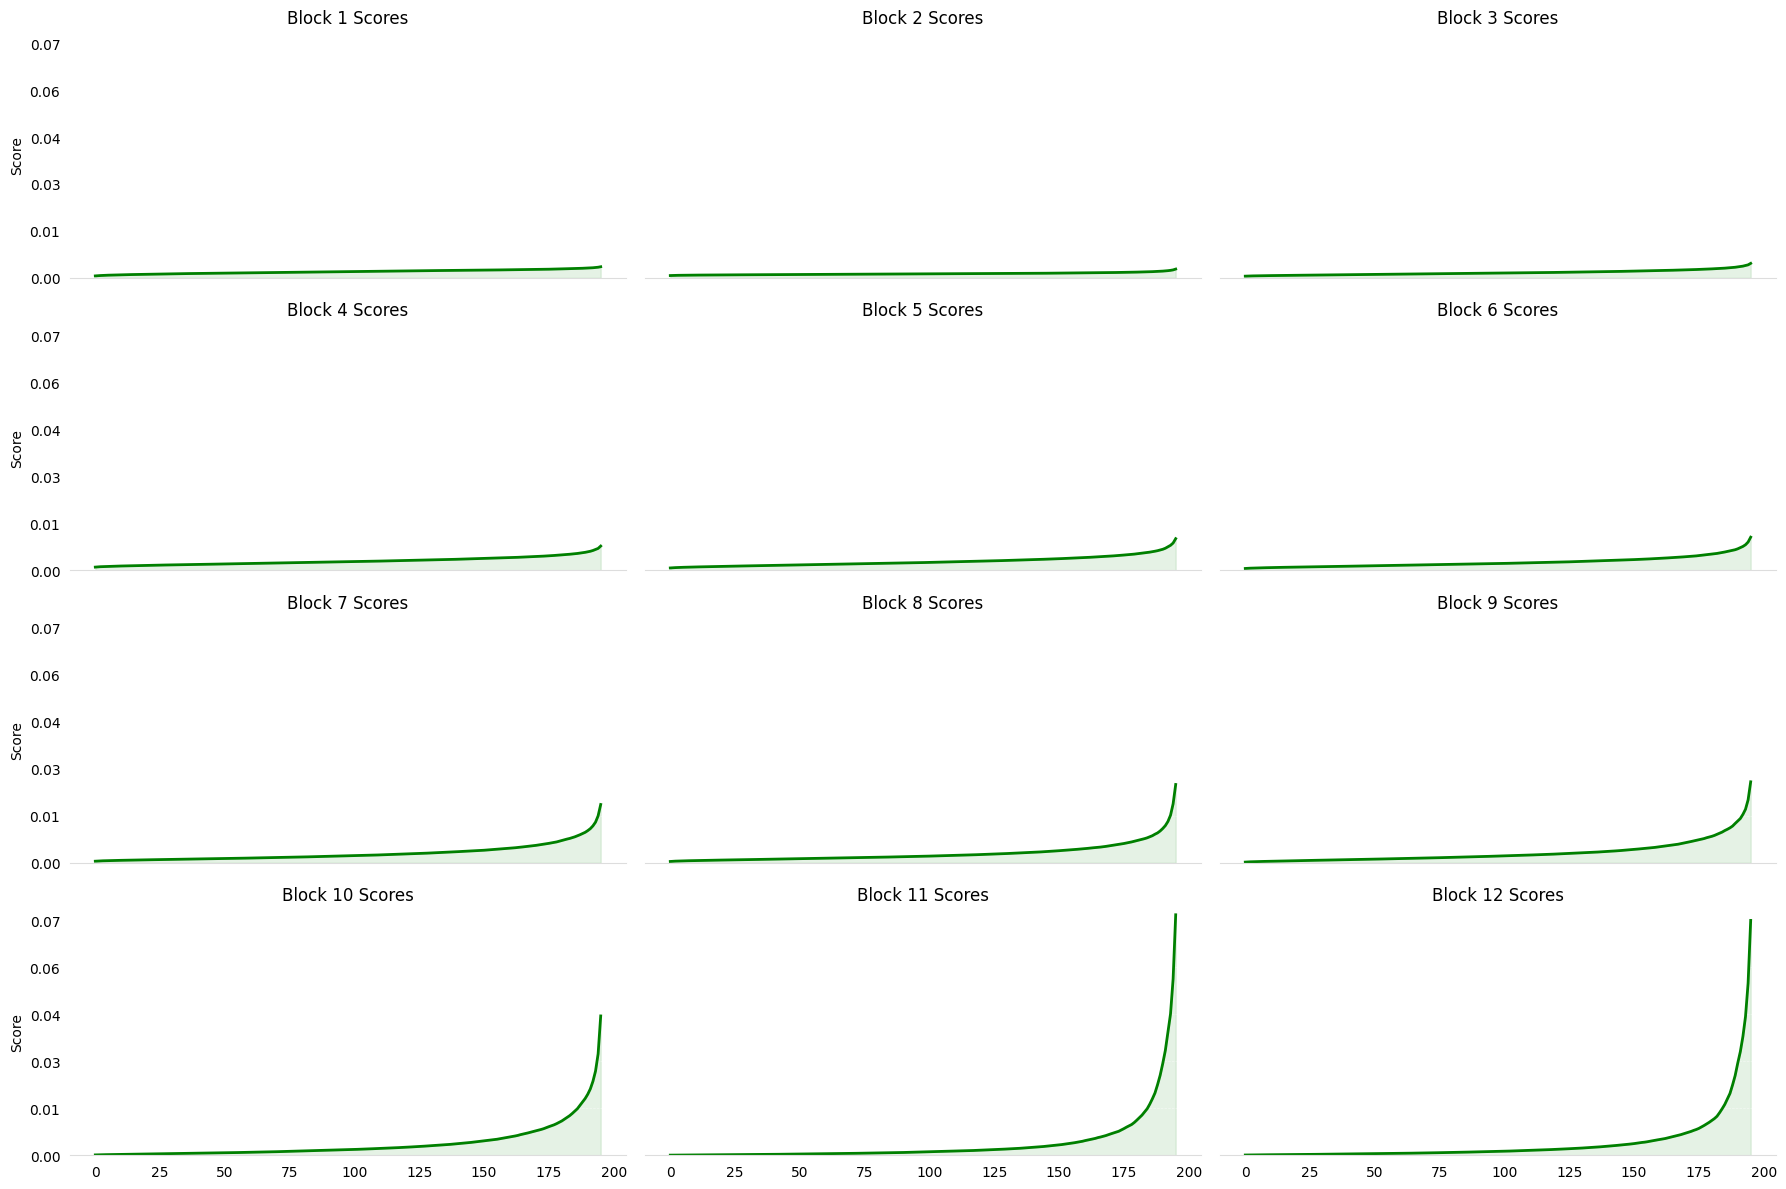

In [23]:
# Create a figure and axis with 4 rows and 3 columns
fig, axs = plt.subplots(nrows=4, ncols=3, figsize=(18, 12), sharex=True, sharey=True)

# Flatten the axis array for easier indexing
axs = axs.flatten()

# Loop through each block and plot sorted values
for i, ax in enumerate(axs):
    # Convert the block's mean scores to NumPy array
    mean_scores_array = np.array(mean_scores[i])
    # Sort the values (if needed)
    overall_mean = np.mean(mean_scores_array, axis=0)
    sorted_values = np.sort(overall_mean)
    
    # Create indices for x-axis
    indices = np.arange(len(sorted_values))
    
    # Plot the sorted values against the indices using seaborn
    sns.lineplot(x=indices, y=sorted_values, ax=ax, linewidth=2, color='green')
    
    # Shade the area below the line
    ax.fill_between(indices, sorted_values, color='green', alpha=0.1)
    
    # Simplify the plot by removing spines and ticks
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_color('#DDDDDD')
    ax.tick_params(bottom=False, left=False)
    
    # Set the title with a simpler style
    ax.set_title(f'Block {i+1} Scores', fontsize=12)
    
    # Set x-axis label for the bottom row
    if i // 3 == 3 - 1:
        ax.set_xlabel('Index', fontsize=10)
    
    # Set y-axis label for the leftmost column
    if i % 3 == 0:
        ax.set_ylabel('Score', fontsize=10)
    
    # Adjust y-axis limits
    ax.set_ylim(bottom=0, top=max(sorted_values)*1.05)
    
    # Set custom y-axis tick marks and labels
    y_ticks = np.arange(0, max(sorted_values)*1.05, step=max(sorted_values)/5)
    y_labels = [f"{val:.2f}" for val in y_ticks]
    ax.set_yticks(y_ticks)
    ax.set_yticklabels(y_labels)
    
    # Reduce grid to horizontal lines only and style them minimally
    ax.grid(axis='y', color='white', linestyle='--', linewidth=0.5, alpha=0.5)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

# Saliency Maps

In [24]:
save_dir = '/kaggle/working/saliency_maps/'
# Create the directory if it doesn't exist
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

In [25]:
for idx, (img, _) in tqdm(enumerate(data_loader)):
    if idx >= 100:
        break

    x = img.to(device)  # Move input to the same device as the model
    y = model(x)
    
    attn_maps = []
    cls_weights = []
    for block in tqdm(model.blocks):
        attn_maps.append(block.attn.attn_map.max(dim=1).values.squeeze(0).detach().cpu())
        cls_weights.append(block.attn.cls_attn_map.mean(dim=1).view(14, 14).detach().cpu())
    
    img_resized = x.squeeze(0).permute(1, 2, 0) * 0.5 + 0.5
    img_resized_cpu = img_resized.cpu()

    plot_cls_weights(cls_weights, img_resized_cpu, os.path.join(save_dir, f'{idx}_saliencymap.png'))

0it [00:00, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]